<a href="https://colab.research.google.com/github/karen-pal/notebooks/blob/master/riffusion_works_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# riffusion colab demo

Run [riffusion](https://www.riffusion.com/about) in a gradio demo with a colab host

Riffusion project by [Seth Forsgren](https://twitter.com/sethforsgren) and [Hayk Martiros](https://github.com/hmartiro), colab notebook by [Jasper Gilley](https://twitter.com/0xjasper)

Feel free to DM Jasper on Twitter if you have any problems with the notebook

Some cool prompt ideas can be found at https://ai-art-wiki.com/wiki/Riffusion#Prompts

In [1]:
!nvidia-smi

Wed Feb 22 22:57:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Clone the inference repo
!git clone https://github.com/hmartiro/riffusion-inference
%cd riffusion-inference

fatal: destination path 'riffusion-inference' already exists and is not an empty directory.
/content/riffusion-inference


In [2]:
#@title Install requirements (you may need to restart the kernel after this)
!pip install -r requirements.txt
!pip install gradio
!pip install --upgrade pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.4.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.4 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.1.0
    Uninstalling Pillow-9.1.0:
      Successfully uninstalled Pillow-9.1.0


In [3]:
!pip install Pillow==9.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [4]:
#@title Imports
from diffusers import DiffusionPipeline
from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams
from io import BytesIO
from IPython.display import Audio

pipe = DiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:156: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the following: 
- CompVis/stable-diffusion-v1-4 
- CompVis/stable-diffusion-v1-3 
- CompVis/stable-diffusion-v1-2 
- CompVis/stable-diffusion-v1-1 
- runwayml/stable-diffusion-v1-5 
- runwayml/stable-diffusion-inpainting 
 you should change 'sample_size' to 64 in the configuration file. Please make sure to update the config accordingly as leaving `sample_size=32` in the config might lead to incorrect results in future versions. If you have 

In [5]:
#@title Define a `predict` function

params = SpectrogramParams()
converter = SpectrogramImageConverter(params)

def predict(prompt, negative_prompt):
    spec = pipe(
        prompt,
        negative_prompt=negative_prompt,
        width=512,
    ).images[0]
    
    wav = converter.audio_from_spectrogram_image(image=spec)
    wav.export('output.wav', format='wav')
    return 'output.wav', spec

  0%|          | 0/50 [00:00<?, ?it/s]

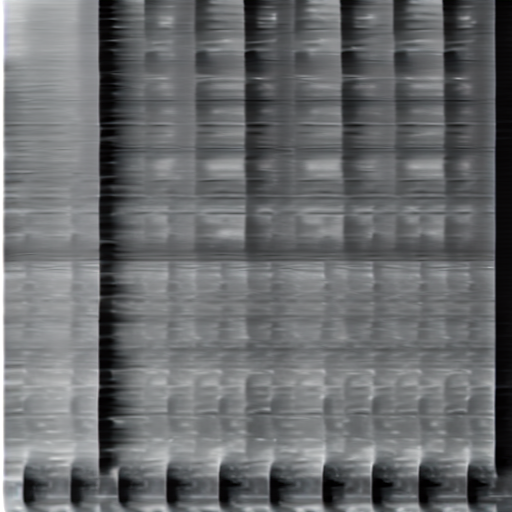

In [6]:
#@title Run with Colab interface
prompt = "drums"#@param {type:"string"}
negative_prompt = "classical"#@param {type:"string"}

path, spec = predict(prompt, negative_prompt)

display(spec)
Audio('output.wav')

In [ ]:
#@title Run a Gradio demo
import gradio as gr

gr.Interface(
    predict,
    inputs=["text", "text"],
    outputs=[gr.outputs.Audio(type='filepath'), gr.outputs.Image(type='pil')],
    title="Riffusion",
).launch(share=True, debug=True)

In [ ]:
#@title Upload your own files for style transfer
#@markdown #### Drop your audio files (.wav is best) in Colab's file uploader, then type the filename below and run

from google.colab import files
# uploaded = files.upload()

from scipy.io import wavfile
import numpy as np
from PIL import Image

filename = "rondo_alla_turca.wav"#@param {type:"string"}

# read uploaded file to wav
rate, data = wavfile.read(f'../{filename}')

# resample from 48000 to 44100
# from scipy.signal import resample
# data = resample(data, int(data.shape[0] * 44100 / 48000))

# convert to mono
data = np.mean(data, axis=1)

# convert to float32
data = data.astype(np.float32)

# take a random 7 second slice of the audio
data = data[rate*7:rate*14]

spectrogram = spectrogram_from_waveform(
    waveform=data,
    sample_rate=rate,
    # width=768,
    n_fft=8192,
    hop_length=512,
    win_length=8192,
)

def image_from_spectrogram(
    spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25
) -> Image.Image:
    """
    Compute a spectrogram image from a spectrogram magnitude array.
    """
    # Apply the power curve
    data = np.power(spectrogram, power_for_image)

    # Rescale to 0-255
    data = data * 255 / max_volume

    # Invert
    data = 255 - data

    # Convert to a PIL image
    image = Image.fromarray(data.astype(np.uint8))

    # Flip Y
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Convert to RGB
    image = image.convert("RGB")

    return image

spec = image_from_spectrogram(spectrogram)
# img.save('../rondo_alla_turca.png')
# display(img)

# Audio(data, rate=rate)

# wav2 = wav_bytes_from_spectrogram_image(img)
# with open("../inverse-spectro.wav", "wb") as f:
#     f.write(wav2[0].getbuffer())

# Audio('../inverse-spectro.wav')

In [ ]:
#@title Audio-to-audio based on the previous generated sound: define new pipeline

import torch
from diffusers import StableDiffusionImg2ImgPipeline

# load the pipeline
device = "cuda"
MODEL_ID = "riffusion/riffusion-model-v1"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16)

pipe = pipe.to(device)

#### NOTE: Colab doesn't have enough memory to simultaneously load both the base riffusion pipeline and the audio2audio pipeline. You'll need to re-run the first 'imports' cell if you want to run regular riffusion after instantiating the audio2audio pipeline in in this cell

#### you can run the audio2audio inference cell (below) as many times as you like, though

In [ ]:
#@title Audio-to-audio: run inference
prompt = "epic orchestra symphony" #@param {type:"string"}

images = pipe(
    prompt=prompt,
    image=spec,
    strength=0.5,
    guidance_scale=7
).images

wav = converter.audio_from_spectrogram_image(images[0])
wav.export('audio2audio.wav', format='wav')
Audio('audio2audio.wav')